# PYRAWS - Bounding box homography transformation

This notebook is to show and demonstrate how to transfer the bounding box produced by [pyraws_Raw_API_demonstration](../API_demonstration/pyraws_Raw_API_demonstration.ipynb) from `L1C` data to the `Raw` couterpart by exploiting two main items:

+ lightglue [Philipp, Lindenberger, et al.](https://openaccess.thecvf.com/content/ICCV2023/papers/Lindenberger_LightGlue_Local_Feature_Matching_at_Light_Speed_ICCV_2023_paper.pdf): to perform features matching between L1C and Raw data
+ homography projection: to transform the coordinates of the bounding box from L1C to Raw data

The notebook performs the features matching with lightglue by importing presaved images from the `test` folder and then appies an homography transformation to bring the bbox from `L1C` to `Raw`

# 0) - Pull lightglue and basic imports

In [1]:
#pull lightglue
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

/Users/francesco/Desktop/Privato/GitHub/contributions/PyRawS/quickstart/BBOX_L1C2RAW/LightGlue


In [2]:
#lightglue imports
from lightglue import LightGlue, SuperPoint
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
torch.set_grad_enabled(False)
images = Path("assets")

#pyraws imports
import os
os.chdir('../')
import sys
sys.path.insert(1, os.path.join("..", ".."))
sys.path.insert(1, os.path.join("..", "..", "scripts_and_studies", "hta_detection_algorithms"))
from s2pix_detector import s2pix_detector
from pyraws.l1.l1_event import L1C_event
from pyraws.utils.l1_utils import read_L1C_image_from_tif
from skimage.measure import label, regionprops
import matplotlib.patches as patches

#homography transformation imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) - Setup basic variables

In [3]:
#device definition
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'
#lightglue load extractor and matcher
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)
matcher = LightGlue(features="superpoint").eval().to(device)

To create load the right images and define the `L1C_event` object later on,  please specify the `requested_bands` and the requested `event_name`.

In [4]:
#define args for L1C events
event_name = 'Greece_5'
requested_bands=["B8A","B11","B12"]

In [5]:
#declare events names (they need to be)
raw_name = f'raw_{event_name}.jpg'
l1c_name = f'l1c_{event_name}.jpg'

# 2) - Perfrorm features matching with lightlgue

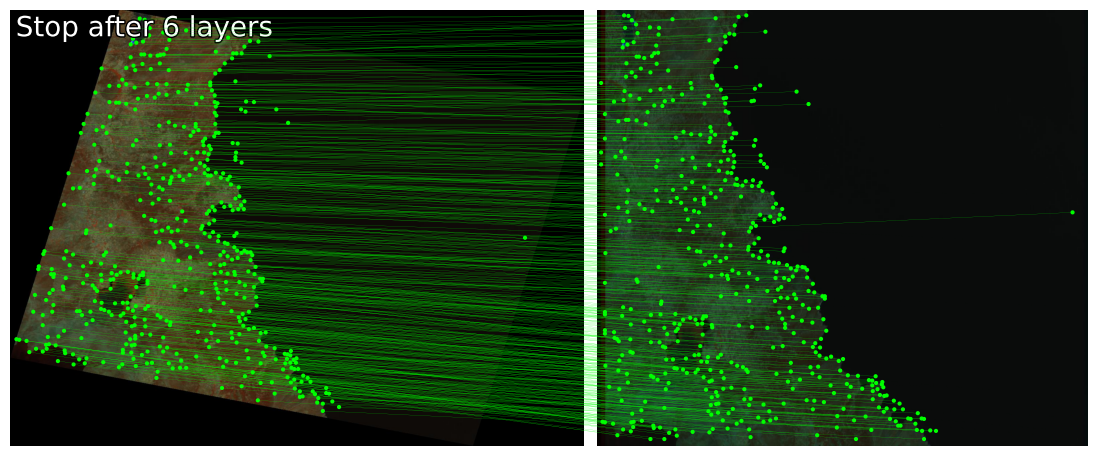

In [6]:
### features matching ###

#import the two images
image0 = load_image(f"tests/{l1c_name}")
image1 = load_image(f"tests/{raw_name}")

#run extractor and matcher
feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])

viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.1)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)


# 2) - Compute homography transformation

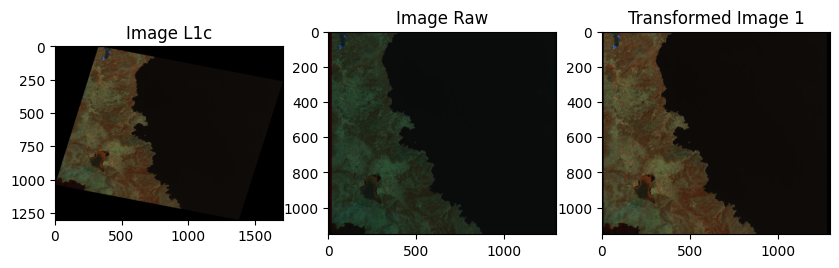

In [7]:
### HOMOGRAPHY TRANSFORMATION ###

# Load the images
image_l1c = cv2.imread(f"tests/{l1c_name}")
image_raw = cv2.imread(f"tests/{raw_name}")

# reassign matching pixel coordinates in both images
# They should be in the form of numpy arrays with shape (N, 2)
match_pts1 = m_kpts0.numpy()
match_pts2 = m_kpts1.numpy()

# Calculate the homography matrix
# RANSAC to improve robusness of the homography matrix. Discards some outliers (status vector)
H, status = cv2.findHomography(match_pts1, match_pts2, cv2.RANSAC)

# Apply the homography transformation to image1
height, width, channels = image_raw.shape
transformed_image = cv2.warpPerspective(image_l1c, H, (width, height))

# Display the original and transformed images
plt.figure(figsize=(10, 5))
#L1C
plt.subplot(1, 3, 1)
plt.title('Image L1c')
plt.imshow(cv2.cvtColor(image_l1c, cv2.COLOR_BGR2RGB))
#Raw
plt.subplot(1, 3, 2)
plt.title('Image Raw')
plt.imshow(cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB))
#Transformed
plt.subplot(1, 3, 3)
plt.title('Transformed Image 1')
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))

plt.show()

In [8]:
#print shapes of the two images before and after the transformation
print("BEFORE")
print(f"Raw image shape: {image_raw.shape}")
print(f"L1C image shape: {image_l1c.shape}")

print("\nAFTER")
print(f"Raw image shape: {image_raw.shape}")
print(f"L1C image shape: {transformed_image.shape}")

BEFORE
Raw image shape: (1152, 1296, 3)
L1C image shape: (1301, 1711, 3)

AFTER
Raw image shape: (1152, 1296, 3)
L1C image shape: (1152, 1296, 3)


# 3) - Project the bbox from L1C to Raw

In [9]:
#instantiate L1C event
l1c_event=L1C_event(device=device)
l1c_event.from_database(event_name, requested_bands)

Parsing tiles...: 0it [00:00, ?it/s]

Taking band: B8A


Taking band: B11


Taking band: B12


Parsing sentinel bands: 100%|██████████| 3/3 [00:03<00:00,  1.00s/it]
Parsing tiles...: 1it [00:03,  3.01s/it]

Taking band: B8A


Taking band: B11


Taking band: B12


Parsing sentinel bands: 100%|██████████| 3/3 [00:02<00:00,  1.01it/s]
Parsing tiles...: 2it [00:05,  3.00s/it]


In [10]:
ending="2"
l1c_tif, coords_dict, expected_class=read_L1C_image_from_tif(event_name, ending, device=device)

## 3.a) - Plot of the original result (no projection)

/Users/francesco/Desktop/Privato/GitHub/contributions/PyRawS/quickstart/BBOX_L1C2RAW/../../scripts_and_studies/hta_detection_algorithms/s2pix_detector.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(img_pad, dtype=torch.float32, device=img_pad.device)
/Users/francesco/Desktop/Privato/GitHub/contributions/PyRawS/quickstart/BBOX_L1C2RAW/../../scripts_and_studies/hta_detection_algorithms/s2pix_detector.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conv(torch.tensor(img_pad, dtype=torch.float32).unsqueeze(0).unsqueeze(0))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4699].


Found bbox (41, 404, 55, 417)
Found bbox (56, 415, 58, 417)
Found bbox (63, 404, 64, 405)
Found bbox (63, 411, 64, 412)
Found bbox (86, 360, 103, 378)


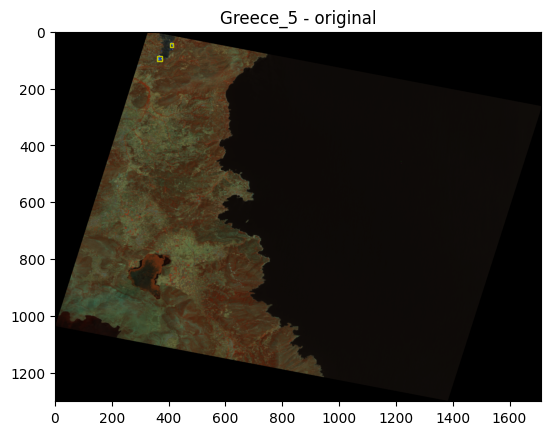

In [11]:
_, l1c_filtered_alert_matrix, l1c_alert_matrix=s2pix_detector(l1c_tif)
mask=l1c_filtered_alert_matrix.numpy()
lbl = label(mask)
props = regionprops(lbl)
l1c_numpy=l1c_tif.numpy()
fig, ax = plt.subplots()
ax.imshow(l1c_tif)
for prop in props:
     print('Found bbox', prop.bbox)
     bbox = prop.bbox         #   x,       y,        width, height
     rect = patches.Rectangle((bbox[1], bbox[0]), abs(bbox[1]-bbox[3]), abs(bbox[0]-bbox[2]), linewidth=1, edgecolor='y', facecolor='none')
     ax.add_patch(rect)
     ax.set_title(f"{event_name} - original")
     
plt.savefig(f"results/{event_name}_original.pdf")    
plt.show()

## 3.b) - Plot of the reprojected result

the following function is aimed at tranformig the cooridnates of each point of the boundingbox

In [12]:
def project_bbox(bbox):
    #assign coords pt1
    x_0 = bbox[1]
    y_0 = bbox[0]
    #assign coords pt2
    x_1 = bbox[3]
    y_1 = bbox[2]
    # save all points to be transformed in pts 
    pts = np.float32([[x_0, y_0], [x_1, y_1]]).reshape(-1, 1, 2)  
    # apply perspective algorithm
    dst = cv2.perspectiveTransform(pts, H).squeeze()
    #re-create bbox in the original fomrat (y_0,x_0,y_1,x_1)
    bbox = (int(dst[0][1]),int(dst[0][0]),int(dst[1][1]),int(dst[1][0]))

    return bbox

/Users/francesco/Desktop/Privato/GitHub/contributions/PyRawS/quickstart/BBOX_L1C2RAW/../../scripts_and_studies/hta_detection_algorithms/s2pix_detector.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(img_pad, dtype=torch.float32, device=img_pad.device)
/Users/francesco/Desktop/Privato/GitHub/contributions/PyRawS/quickstart/BBOX_L1C2RAW/../../scripts_and_studies/hta_detection_algorithms/s2pix_detector.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conv(torch.tensor(img_pad, dtype=torch.float32).unsqueeze(0).unsqueeze(0))


Found bbox (before projection) (41, 404, 55, 417)
Found bbox (after projection) (41, 404, 55, 417)
Found bbox (before projection) (56, 415, 58, 417)
Found bbox (after projection) (56, 415, 58, 417)
Found bbox (before projection) (63, 404, 64, 405)
Found bbox (after projection) (63, 404, 64, 405)
Found bbox (before projection) (63, 411, 64, 412)
Found bbox (after projection) (63, 411, 64, 412)
Found bbox (before projection) (86, 360, 103, 378)
Found bbox (after projection) (86, 360, 103, 378)


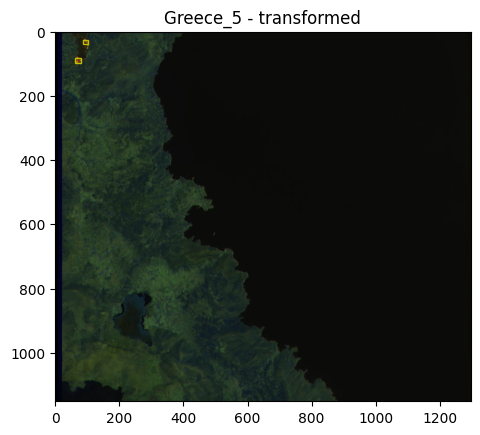

In [13]:
#plot the  result
_, l1c_filtered_alert_matrix, l1c_alert_matrix=s2pix_detector(l1c_tif)
mask=l1c_filtered_alert_matrix.numpy()
lbl = label(mask)
props = regionprops(lbl)
l1c_numpy=l1c_tif.numpy()
fig, ax = plt.subplots()
ax.imshow(image_raw)
for prop in props:
     print('Found bbox (before projection)', prop.bbox)
     bbox = project_bbox(prop.bbox)
     print('Found bbox (after projection)', prop.bbox)
     rect = patches.Rectangle((bbox[1], bbox[0]), abs(bbox[1]-bbox[3]), abs(bbox[0]-bbox[2]), linewidth=1, edgecolor='y', facecolor='none')
     ax.add_patch(rect)
     ax.set_title(f"{event_name} - transformed")
plt.savefig(f"results/{event_name}_transformed.pdf")
plt.show()